In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')


Mounted at /content/gdrive


In [230]:
%matplotlib inline
import my_utils as mu
import math
import torch
from torch import nn
from torch.nn import functional as F

# Concise Implementation of RNNs

* Here we will see how to implement the same language model more efficiently using functions provided by Pytorch.


# Loading the Dataset

In [231]:
batch_size, num_steps = 32, 35
train_iter, vocab = mu.load_data_time_machine(batch_size, num_steps)

In [232]:
print(list(vocab.token_to_idx.items())[:])

[('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)]


In [233]:
train_iterator = iter(train_iter)

In [234]:
batch_1 = next(train_iterator)

In [235]:
sample_1 = batch_1[0][1, :]

In [236]:
sample_1

tensor([ 9,  2,  1, 21, 14, 21, 21, 12,  2,  8,  1,  3,  9,  4,  3,  1, 16, 12,
         4,  8,  9,  2, 11,  1,  4,  6, 11, 20,  4,  8,  8,  2, 11,  1,  5])

In [237]:
sample_token = [vocab.idx_to_token[idx] for idx in sample_1]
print(sample_token)

['h', 'e', ' ', 'b', 'u', 'b', 'b', 'l', 'e', 's', ' ', 't', 'h', 'a', 't', ' ', 'f', 'l', 'a', 's', 'h', 'e', 'd', ' ', 'a', 'n', 'd', 'p', 'a', 's', 's', 'e', 'd', ' ', 'i']


In [249]:
sample_1_y = batch_1[1][1, :]
print(sample_1_y)

tensor([ 2,  1, 21, 14, 21, 21, 12,  2,  8,  1,  3,  9,  4,  3,  1, 16, 12,  4,
         8,  9,  2, 11,  1,  4,  6, 11, 20,  4,  8,  8,  2, 11,  1,  5,  6])


# Defining the Model


In [239]:
# An RNN with a single hidden layer and 256 hidden units.
num_hiddens = 256 
rnn_layer = nn.RNN(input_size = len(vocab), hidden_size= num_hiddens)

In [240]:
# A tensor is used to initialize the hidden state
state = torch.zeros((1, batch_size, num_hiddens))
state.size() #number of hidden layers x batch size x number of hidden units

torch.Size([1, 32, 256])

* Given the previous hidden state and an input, we can compute the updated hidden state.
* The "output" (`Y`) of `rnn_layer` refers to the hidden state at *each* time step, not the output of the model.


In [241]:
X = torch.rand(num_steps, batch_size, len(vocab))
X.size()

torch.Size([35, 32, 28])

In [242]:
Y, state_new = rnn_layer(X, state)
Y.size(), state_new.size()

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [243]:
# RNNModel class contains a complete RNN model.
# rnn_layer only contains the hidden recurrent layers, we need to create a separate output layer.
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        #print(X.size()) # 35x32x28
        #print(Y.size()) # 35x32x256
        #print(state.size()) # 32x256
        Y1 = Y.reshape((-1, Y.shape[-1]))
        #print(Y1.size()) # 1120x256
        out = self.linear(Y1) 
        #print(out.size()) # 1120x28
        return out, state

    def begin_state(self, batch_size=1):
        state = torch.zeros((self.rnn.num_layers, batch_size, self.num_hiddens))
        return state 

# Training and Predicting

* Before training the model, let us make a prediction with the a model that has random weights.


In [244]:
def predict_ch8(prefix, num_preds, model, vocab):  
    """Generate new characters following the `prefix`."""
    state = model.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: mu.reshape(torch.tensor([outputs[-1]]), (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [245]:
model = RNNModel(rnn_layer, vocab_size=len(vocab))
predict_ch8('time traveller', 10, model, vocab)

'time travellerrrrrrrrrrr'

* Training with `train_ch8` with the same hyperparameters as before


In [255]:
def train_epoch_ch8(model, train_iter, loss, optimizer, use_random_iter):
    """Train a model for one epoch """
    state = None
    metric = mu.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        # Initialize `state` when first iteration or using random sampling
        if state is None or use_random_iter:
            state = model.begin_state(batch_size=X.shape[0])
        #print(X.size(), Y.size(), state.size()) # 32x35, 32x35, 32x256
        y = Y.T.reshape(-1) 
        #print(y.size()) # 35x32 -> 1120 
        y_hat, state = model(X, state)
        #print(y_hat.size()) # 1120x28 
        l = loss(y_hat, y.long())
        optimizer.zero_grad()
        l.backward()
        mu.grad_clipping(model, 1)
        optimizer.step()
    
        metric.add(l * mu.size(y), mu.size(y))
    return math.exp(metric[0] / metric[1])

In [256]:
def train_ch8(model, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    """Train a model for num_epochs"""
    animator = mu.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[1, num_epochs])
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch_ch8(model, train_iter, loss, optimizer, use_random_iter)
        if epoch % 10 == 0:
            print(predict_ch8('time traveller', 50, model, vocab))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}')
    print(predict_ch8('time traveller', 50, model, vocab))
    print(predict_ch8('traveller', 50, model, vocab))

perplexity 2.8
time traveller sith o  finke dereetlly hof are muthedi ione simn
traveller  mens a song tace ais reabllyre munn ard the is i


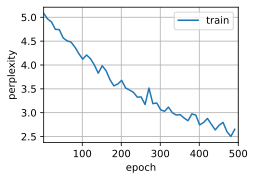

In [257]:
num_epochs, lr = 500, 0.1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# Summary

* PyTorch provides an implementation of the RNN layer.
* The RNN layer of PyTorch returns an output and an updated hidden state, where the output does not involve output layer computation.
